### Naive Bayes Classifier

- Hem vist que en el cas del dataset Iris el Bayessian Classifier és molt robust.
- Però hi ha molts casos en que un classificador bayessià pot ser inviable:
    - $X$ conté a la vegada atributs continus i discrets (categòrics, ordinals);
    - $X$ està format per un número elevat d'atributs (alguns d'ells amb vàries categories);
    - les dues coses a la vegada.
- En qualsevol d'aquests casos la dimensió de la distribució $P\left(X|Y\right)$ és tan elevada que caldrien moltíssims exemples per tenir una bona representació del domini i de com es distribueix la probabilitat cojuntament.
- El Naive Bayes Classifier soluciona exactament això.
- La solució és molt "naïf" (d'aquí el nom) ja que consisteix en assumir que els atributs d'entrada són independents entre ells, es a dir:

$$
\text{donat}\; X=\{X^1, X^2, \dots, X^m\},\; \text{assumim que}\;P\left(X|Y\right) = P\left(X^1|Y\right)\,P\left(X^2|Y\right)\,\dots\,P\left(X^m|Y\right) = \prod_{j=1}^{m}\,P\left(X^j|Y\right)
$$

- Sota aquesta assumpció no cal calcular la distribució condicional conjunta $P\left(X|Y\right)$ sino que calcularem la distribució condicional de cada atribut respecte a la classe $P\left(X^j|Y\right)$ (funcions de versemblança independents)
- Amb això, la distribució a posteriori (Teorema de Bayes) queda:

$$
P\left(Y|X\right)\approxeq\,P\left(Y\right)\;\prod_{j=1}^m\,P\left(X^j|Y\right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()

#### Exemple: Heart-Disease dataset

- Description (14 attributes):


    - 01. 3  (age)       age in years
    - 02. 4  (sex)       (1 = male; 0 = female)
    - 03. 9  (cp)        chest pain type
                            - 1: typical angina
                            - 2: atypical angina
                            - 3: non-anginal pain
                            - 4: asymptomatic
    - 04. 10 (restbps)   resting blood pressure (in mm Hg on admission to the hospital)
    - 05. 12 (chol)      serum cholestoral in mg/dl
    - 06. 16 (fbs)       (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
    - 07. 19 (restecg)   resting electrocardiographic results
                            - 0: normal
                            - 1: having ST-T wave abnormality (T wave inversions and/or ST
                            elevation or depression of > 0.05 mV)
                            - 2: showing probable or definite left ventricular hypertrophy
                            by Estes' criteria
    - 08. 32 (thalach)   maximum heart rate achieved
    - 09. 38 (exang)     exercise induced angina (1 = yes; 0 = no)
    - 10. 40 (oldpeak)   ST depression induced by exercise relative to rest 
    - 11. 41 (slope)     the slope of the peak exercise ST segment:
                            - 1: upsloping
                            - 2: flat
                            - 3: downsloping
    - 12. 44 (ca)        number of major vessels (0-3) colored by flourosopy 
    - 13. 51 (thal)      3 = normal; 6 = fixed defect; 7 = reversable defect 
    - 14. 58 (num)       diagnosis of heart disease (angiographic disease status, the predicted attribute)
                            - 0: < 50% diameter narrowing
                            - 1: > 50% diameter narrowing 


##### name and type of the variables

In [2]:
# 0: discrete
# 1: continuos
X = {'age': 1,
     'sex': 0,
     'cp': 0,
     'restbps': 1,
     'chol': 1,
     'fbs': 0,
     'restecg': 0,
     'thalach': 1,
     'exang': 0,
     'oldpeak': 1,
     'slope': 0,
     'ca': 0,
     'thal': 0}
Y = ['target']

In [3]:
df = pd.read_csv('../../data/heartdisease/processed.cleveland.data', names  = [x for x in X.keys()] +Y)

In [4]:
df.head()

,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


#### Data exploration

##### dependent variable (target)

- 0: no disease; 1-4: disease severity level

In [5]:
df.target.value_counts(normalize = True)

0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: target, dtype: float64

- reduce to a binary variable (no_disease/disease)

In [6]:
df['target'] = df['target'].apply(lambda x: x > 0)

In [7]:
df.groupby('target').target.value_counts()

target  target
False   False     164
True    True      139
Name: target, dtype: int64

##### independent variables (attributes)

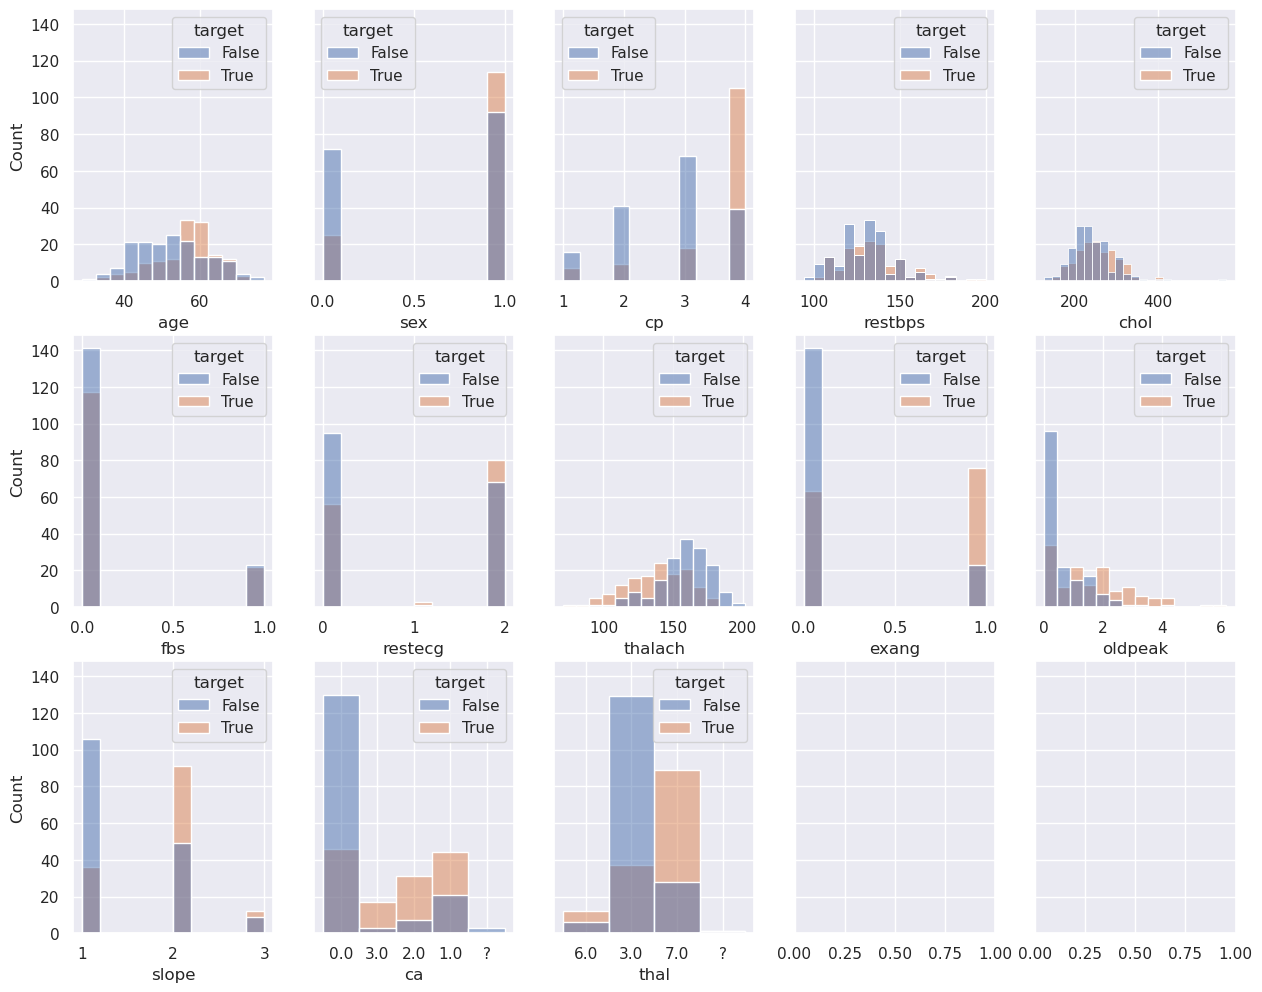

In [8]:
fig, axs = plt.subplots(3, 5, figsize = (15, 12), sharey = True)
for axi, Xj in zip(axs.flatten()[:-1], X):
    sns.histplot(ax = axi, data = df, x = Xj, hue = 'target')

In [9]:
df.describe()

,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      303 non-null    float64
 1   sex      303 non-null    float64
 2   cp       303 non-null    float64
 3   restbps  303 non-null    float64
 4   chol     303 non-null    float64
 5   fbs      303 non-null    float64
 6   restecg  303 non-null    float64
 7   thalach  303 non-null    float64
 8   exang    303 non-null    float64
 9   oldpeak  303 non-null    float64
 10  slope    303 non-null    float64
 11  ca       303 non-null    object 
 12  thal     303 non-null    object 
 13  target   303 non-null    bool   
dtypes: bool(1), float64(11), object(2)
memory usage: 31.2+ KB


##### replace undefined values '?' in attributes 'ca' and 'thal'

In [11]:
df.groupby('ca').target.value_counts()

ca   target
0.0  False     130
     True       46
1.0  True       44
     False      21
2.0  True       31
     False       7
3.0  True       17
     False       3
?    False       3
     True        1
Name: target, dtype: int64

In [12]:
df['ca'] = df.ca.apply(lambda x: ['0.0', '1.0', '2.0', '3.0', '?'].index(x))
df.groupby('ca').target.value_counts()

ca  target
0   False     130
    True       46
1   True       44
    False      21
2   True       31
    False       7
3   True       17
    False       3
4   False       3
    True        1
Name: target, dtype: int64

In [13]:
df.groupby('thal').target.value_counts()

thal  target
3.0   False     129
      True       37
6.0   True       12
      False       6
7.0   True       89
      False      28
?     False       1
      True        1
Name: target, dtype: int64

In [14]:
df['thal'] = df.thal.apply(lambda x: ['3.0', '6.0', '7.0', '?'].index(x))
df.groupby('thal').target.value_counts()

thal  target
0     False     129
      True       37
1     True       12
      False       6
2     True       89
      False      28
3     False       1
      True        1
Name: target, dtype: int64

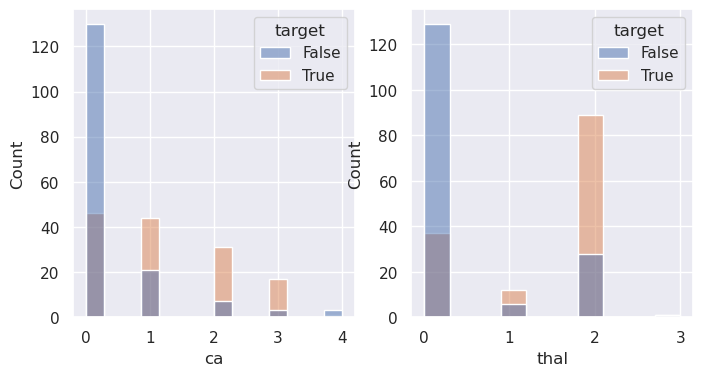

In [15]:
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
for axi, Xj in zip(axs.flatten(), ['ca', 'thal']):
    sns.histplot(ax = axi, data = df, x = Xj, hue = 'target')

#### Likelihood functions  $\;\mathcal{L^{j}}\left(\theta, X^{j}\right)\,\equiv\,P\left(X^j|Y\right)$

In [16]:
from scipy.stats import gaussian_kde

##### likelihood function for discrete variables

In [17]:
lkh0_sex = df.loc[df.target == False].sex.value_counts(normalize = True).sort_index()
lkh1_sex = df.loc[df.target == True].sex.value_counts(normalize = True).sort_index()
lkh0_sex, lkh1_sex

(0.0    0.439024
 1.0    0.560976
 Name: sex, dtype: float64,
 0.0    0.179856
 1.0    0.820144
 Name: sex, dtype: float64)

##### exemple

- com de versemblant (creïble) és trobar un home entre els malalts ??? (proporció d'homes entre els malalts)
- $P\left(X[\text{sex}]=\text{home}\,|Y=\text{malalt}\right)$

In [18]:
lkh1_sex[1]

0.8201438848920863

- com de versemblant és trobar una dona entre els malalts ???
- $P\left(X[\text{sex}]=\text{dona}\,|Y=\text{malalt}\right)$

In [19]:
lkh1_sex[0]

0.17985611510791366

##### likelihood function for continuous variables

In [20]:
lkh0_age = gaussian_kde(df.age.loc[df.target == False], bw_method = 'scott')
lkh1_age = gaussian_kde(df.age.loc[df.target == True], bw_method = 'scott')

##### exemple
- com de versemblant (creïble) és trobar una persona de 31 anys entre els malalts ???
- $P\left(X[\text{age}]=31\,|Y=\text{malalt}\right)$

In [31]:
lkh1_age.evaluate(31)

array([0.00088631])

##### iterative computation of all likelihood functions

In [22]:
lkhDict = {Xj: {'dtype': dt, 'lkh0': None, 'lkh1': None} for Xj, dt in X.items()}

In [23]:
for Xj in X:
    if lkhDict[Xj]['dtype'] == 1:
        lkhDict[Xj]['lkh0'] = gaussian_kde(df[Xj].loc[df.target == False], bw_method = 'scott')
        lkhDict[Xj]['lkh1'] = gaussian_kde(df[Xj].loc[df.target == True], bw_method = 'scott')        
    else:
        lkhDict[Xj]['lkh0'] = {idx: val.item() for idx, val in df[Xj].loc[df.target == False].value_counts(normalize = True).to_frame().iterrows()}
        lkhDict[Xj]['lkh1'] = {idx: val.item() for idx, val in df[Xj].loc[df.target == True].value_counts(normalize = True).to_frame().iterrows()}

In [24]:
for Xj in lkhDict:
    print('--- %s %s' %(Xj, 'continuous' if X[Xj] else 'discrete'))
    print('... lkh_0 %s' %lkhDict[Xj]['lkh0'])
    print('... lkh_1 %s' %lkhDict[Xj]['lkh1'])

--- age continuous
... lkh_0 <scipy.stats._kde.gaussian_kde object at 0x7f429f216950>
... lkh_1 <scipy.stats._kde.gaussian_kde object at 0x7f429f2a4a10>
--- sex discrete
... lkh_0 {1.0: 0.5609756097560976, 0.0: 0.43902439024390244}
... lkh_1 {1.0: 0.8201438848920863, 0.0: 0.17985611510791366}
--- cp discrete
... lkh_0 {3.0: 0.4146341463414634, 2.0: 0.25, 4.0: 0.23780487804878048, 1.0: 0.0975609756097561}
... lkh_1 {4.0: 0.7553956834532374, 3.0: 0.12949640287769784, 2.0: 0.06474820143884892, 1.0: 0.050359712230215826}
--- restbps continuous
... lkh_0 <scipy.stats._kde.gaussian_kde object at 0x7f429f2bf450>
... lkh_1 <scipy.stats._kde.gaussian_kde object at 0x7f429f2bd750>
--- chol continuous
... lkh_0 <scipy.stats._kde.gaussian_kde object at 0x7f429f2bced0>
... lkh_1 <scipy.stats._kde.gaussian_kde object at 0x7f429f2bdf50>
--- fbs discrete
... lkh_0 {0.0: 0.8597560975609756, 1.0: 0.1402439024390244}
... lkh_1 {0.0: 0.841726618705036, 1.0: 0.15827338129496402}
--- restecg discrete
... lk

#### prior

In [25]:
prior0, prior1 = df.target.value_counts(normalize = True).sort_index()
print('--- heart_disease')
print('... False %6.4f' %prior0)
print('... True  %6.4f' %prior1)

--- heart_disease
... False 0.5413
... True  0.4587


#### posterior

In [26]:
def evaluate_post(row):
    post0, post1 = prior0, prior1
    for Xj in lkhDict:
        dt, lkh0, lkh1 = lkhDict[Xj]['dtype'], lkhDict[Xj]['lkh0'], lkhDict[Xj]['lkh1']
        if dt == 1:
            post0 *= lkh0.evaluate(row[Xj])[0]
            post1 *= lkh1.evaluate(row[Xj])[0]
        else:
            post0 *= lkh0[row[Xj]]
            post1 *= lkh1[row[Xj]]
    return post1 > post0

#### evaluate

In [27]:
df['predicted'] = df.apply(lambda row: evaluate_post(row), axis = 1)

In [28]:
df.groupby('target').predicted.value_counts()

target  predicted
False   False        145
        True          19
True    True         117
        False         22
Name: predicted, dtype: int64

In [29]:
df.groupby('target').predicted.value_counts(normalize = True)

target  predicted
False   False        0.884146
        True         0.115854
True    True         0.841727
        False        0.158273
Name: predicted, dtype: float64

In [30]:
pd.concat((df.groupby('target').predicted.value_counts(), df.groupby('target').predicted.value_counts(normalize = True)), axis = 1)

predicted  predicted
target predicted                      
False  False            145   0.884146
       True              19   0.115854
True   True             117   0.841727
       False             22   0.158273